# Feature Engineering: `patsy` as `FormulaTransformer`

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import StandardScaler

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '0.9', 'grid.color': '0.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['figure.dpi'] = 100

## Generate Sample Data
We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [2]:
SEED = 42
np.random.seed(SEED)

# Number of data points.
n = 250
# Create features.
x1 = np.random.normal(loc=0.0, scale=2.0, size=n)
x2 = np.random.normal(loc=0.0, scale=2.0, size=n)
epsilon = np.random.normal(loc=0.0, scale=0.5, size=n)
# Define target variable.
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = 1 / (1 + np.exp(-z))
y = np.random.binomial(n=1, p=p, size=n)

df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))

df.head()

,x1,x2,y
0,0.993428,-2.521768,0
1,-0.276529,1.835724,0
2,1.295377,4.244312,1
3,3.046060,2.064931,1
4,-0.468307,-3.038740,1


In [3]:
df['y'].value_counts() / df['y'].shape[0]

0    0.54
1    0.46
Name: y, dtype: float64

In [4]:
numeric_features = ['x1', 'x2']

x = df[numeric_features]
y = df['y']


x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size=0.7, random_state=SEED
)

## Model Pipeline

In [5]:
class FormulaTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, formula):
        self.formula = formula
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_formula = patsy.dmatrix(formula_like=self.formula, data=X)
        return np.asarray(X_formula)

In [6]:
numeric_transformer = Pipeline(steps=[
    ('formula_transformer', FormulaTransformer(formula='x1 * x2')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features)
])

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C' : np.logspace(-4, 4, 20)},
    scoring='roc_auc',
    cv=10
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gridsearch', grid_search)
])

pipeline = pipeline.fit(X=x_train, y=y_train)

## Predictions and Evaluation Metrics

In [7]:
p_test_pred = pipeline.predict_proba(X=x_test)[:, 1]
y_test_pred = pipeline.predict(X=x_test)

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.787


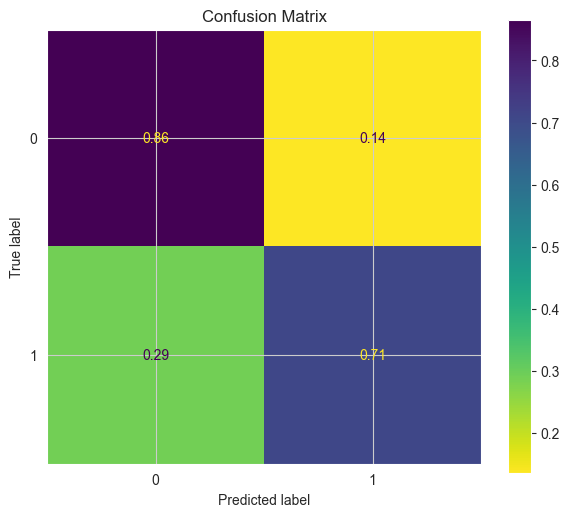

In [8]:
fig, ax = plt.subplots()

plot_confusion_matrix(
    estimator=pipeline, 
    X=x_test,
    y_true=y_test,
    normalize='true',
    cmap='viridis_r',
    ax=ax
)

ax.set(title='Confusion Matrix');

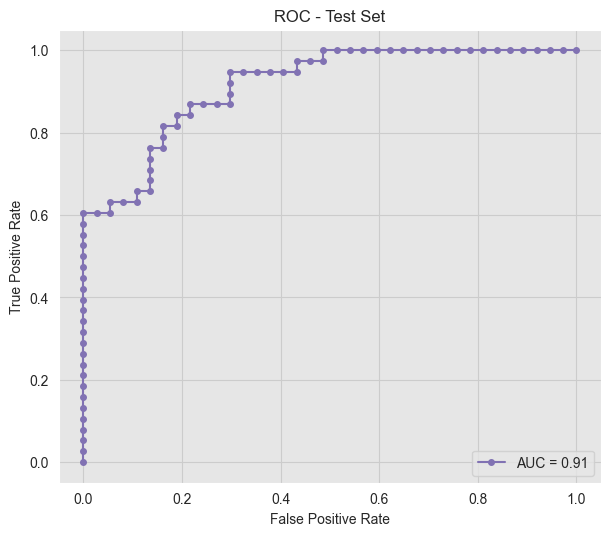

In [9]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", color=sns_c[4], markersize=4)
ax.set(title='ROC - Test Set');

## Partial Dependency Plot

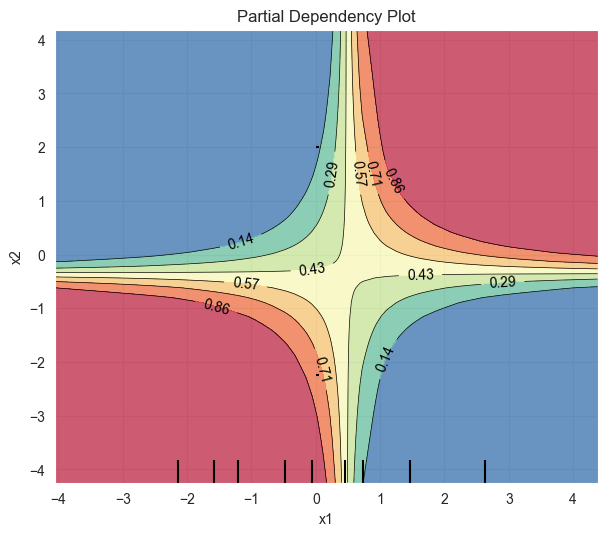

In [10]:
fig, ax = plt.subplots()

cmap = sns.color_palette('Spectral_r', as_cmap=True)

plot_partial_dependence(
    estimator=pipeline,
    X=x_test,
    features=[('x1', 'x2')],
    contour_kw={'cmap': cmap},
    ax=ax
)

ax.set(title='Partial Dependency Plot');